# Transfer learning / fine-tuning




### Project Objective

The project aims to demonstrate and compare the effectiveness of two training approaches for an image classification model, using the problem of distinguishing between dogs and cats. The main goal is to prove that the transfer learning technique, using a pre-trained model such as VGG16, offers superior performance compared to a model trained from scratch.

The experience of developing this project was extremely enriching. To ensure thorough understanding, the practice of documenting and annotating the functionalities of each code block was adopted, which allowed for a deep comprehension of each step and facilitated the review of key concepts.

**Importing my dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Setting up my dataset**

In [ ]:
!mkdir /content/cats_and_dogs_dataset

!unzip /content/drive/MyDrive/MyProjectPets/PetImages.zip -d /content/cats_and_dogs_dataset/

mkdir: cannot create directory ‘/content/cats_and_dogs_dataset’: File exists
Archive:  /content/drive/MyDrive/MyProjectPets/PetImages.zip
replace /content/cats_and_dogs_dataset/PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


**Just checking if my dataset is working correctly.**

In [ ]:
!ls -l /content/cats_and_dogs_dataset/

total 4
drwxr-xr-x 4 root root 4096 Jul 25 21:22 PetImages


In [ ]:
!ls -l /content/cats_and_dogs_dataset/PetImages/

total 184
drwxr-xr-x 2 root root 90112 Jul 30 15:14 Cat
drwxr-xr-x 2 root root 90112 Jul 30 15:12 Dog


**Importing the necessary libraries.**

In [ ]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

**Image preparation**

This function takes each image and transforms it into a format that the neural network can understand by resizing and converting it into numbers.

In [ ]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

**Dataset Settings**

Defines the main path (root folder), categorizes the data, and sets the proportions for splitting the dataset.

In [ ]:
root = '/content/cats_and_dogs_dataset/PetImages'

categories = [os.path.join(root, d) for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
categories = sorted(categories)
train_split, val_split = 0.7, 0.15

**Image Loading and Class Organization**

Loads the images, handles corrupted image errors, and organizes the classes—in this case, two: cat and dog.


In [ ]:
data = []
problematic_images = [] #Imagens que falharam no carregamento

for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        try:
            img, x = get_image(img_path)
            data.append({'x':np.array(x[0]), 'y':c})
        except (IOError, OSError, TypeError) as e:
            problematic_images.append(img_path)
            print(f"AVISO: Pulando imagem corrompida: {img_path} - Erro: {e}")
        except Exception:
            problematic_images.append(img_path)
            print(f"ERRO INESPERADO: Pulando imagem: {img_path} - Erro: {e}")

print(f"\nTotal de imagens carregadas com sucesso: {len(data)}")
if problematic_images:
    print(f"ATENÇÃO: {len(problematic_images)} imagens não puderam ser carregadas e foram puladas.")

# count the number of classes
num_classes = len(categories)


Total de imagens carregadas com sucesso: 7954


**Image Count and Shuffling**

Defines the number of images to be used and shuffles them randomly.

In [ ]:
target_images = 1000
if len(data) > target_images:
    random.shuffle(data)
    data = data[:target_images]

print(f"Total de imagens após a redução: {len(data)}")

Total de imagens após a redução: 1000


**Training Environment Setup**

Creates a controlled training environment so the neural network can truly learn to recognize patterns instead of simply memorizing the images.
Splits the data into three groups: training, validation, and testing (70%, 15%, 15%).

In [ ]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

**Data Splitting into Arrays**

Splits the data into NumPy arrays for images (x) and labels (y).

The code separates the images from their labels, organizing the data for the neural network. The output [0 1 0 1 ...] shows the test labels, where 0 is "cat" and 1 is "dog".

In [ ]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]


**Image Normalization and Label Encoding**

This code normalizes the images to a scale from 0 to 1 and converts the numeric labels into a format that the neural network can process.

In [ ]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(150, 2)


**Final Summary of Data Preparation**

Confirms that all data preparation steps have been successfully completed. Shows the total number of images and categories loaded, the number of images in each set (training, validation, and testing), and the data dimensions.

In [ ]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 1000 images from 2 categories
train / validation / test split: 700, 150, 150
training data shape:  (700, 224, 224, 3)
training labels shape:  (700, 2)


**Visual Tool to Display a Sample of the Dataset**

This code collects all image file paths (jpg, png, jpeg) from the root folder and its subfolders. It then randomly selects 8 images, resizes them to 224x224 pixels, converts them to arrays, and concatenates them side by side into a single image. Finally, it displays this concatenated image as a visual sample of the dataset.

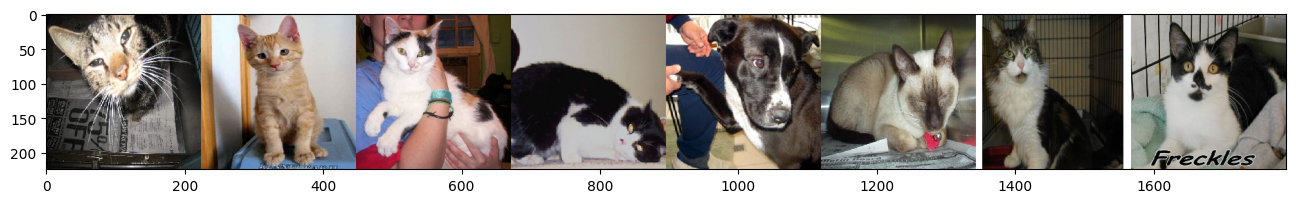

In [ ]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

**Building a Neural Network from Scratch**

This code constructs a neural network from scratch by stacking layers to process the images. The initial Conv2D layers act like detectives, identifying visual patterns. The following layers refine this information until the Dense layers make the final decision, and the softmax layer outputs the probability of the image being a cat or a dog.

In [ ]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

**Model Compilation and Training**

This code prepares the model with the necessary tools to learn, then trains it. The model sees the training images multiple times and adjusts itself to improve its predictions.

In [ ]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.4884 - loss: 0.8393 - val_accuracy: 0.6000 - val_loss: 0.6761
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.4874 - loss: 0.7013 - val_accuracy: 0.6000 - val_loss: 0.6908
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.5076 - loss: 0.6920 - val_accuracy: 0.6000 - val_loss: 0.6895
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.4999 - loss: 0.6915 - val_accuracy: 0.6000 - val_loss: 0.6772
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.5223 - loss: 0.6875 - val_accuracy: 0.6000 - val_loss: 0.6738
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.5361 - loss: 0.6845 - val_accuracy: 0.5933 - val_loss: 0.6702
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.5385 - loss: 0.6791 - val_accuracy: 0.6067 - val_loss: 0.6612
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.6394 - loss: 0.6736 - val_accuracy: 0.6133 - val_loss: 0

**Model Training, Evaluation, and Visualization**

The code trains the model to learn image classification, then evaluates it with a final test. Finally, it displays the results and performance through graphs.

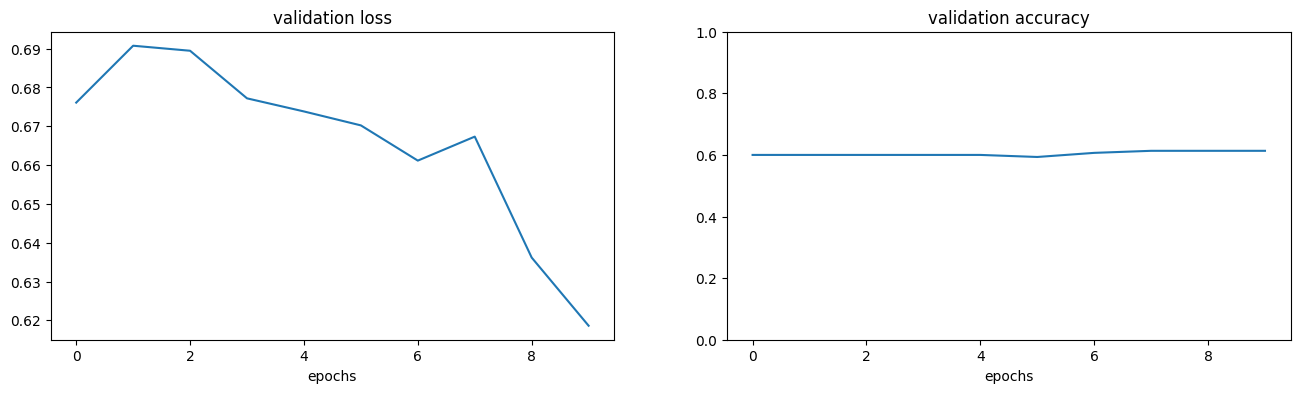

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

**Test Results Output**

The output shows the Test loss, which is the final error score, and the Test accuracy, which is the percentage of correct predictions.

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.638960599899292
Test accuracy: 0.7066666483879089




## Transfer learning by starting with existing network

A ready-made neural network model.

In [ ]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

**Adapting a Pretrained VGG16 Model for Transfer Learning**

This code takes the pretrained VGG16 model (already "expert") and adds a new decision layer at the end. This new softmax layer, with num_classes neurons, is connected to the second-to-last layer of VGG16. The new layer will be trained specifically to classify the images as cats or dogs, leveraging all the knowledge VGG16 has already learned.

In [ ]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


**Freezing Pretrained Layers and Training Only the New Classifier**

This code freezes almost all layers of the VGG16-based model, preserving its learned features. Only the last layer (the custom classifier for cats and dogs) is left trainable, allowing it to learn to distinguish between the categories. This approach makes training much faster and more efficient, as most of the network’s parameters remain unchanged.

In [ ]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

**Training the Transfer Learning Model**

This is where the transfer learning model actually learns. It uses the extensive feature knowledge from VGG16 and applies it specifically to the task of classifying cats and dogs. The model processes the training set over 10 epochs, learning in batches of 128 images, while using the validation set to monitor its performance.

In [ ]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 67s 6s/step - accuracy: 0.5234 - loss: 0.9044 - val_accuracy: 0.7133 - val_loss: 0.5971
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 791ms/step - accuracy: 0.6383 - loss: 0.6239 - val_accuracy: 0.5000 - val_loss: 0.7812
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 786ms/step - accuracy: 0.6175 - loss: 0.6194 - val_accuracy: 0.7867 - val_loss: 0.4864
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 686ms/step - accuracy: 0.8268 - loss: 0.4569 - val_accuracy: 0.7467 - val_loss: 0.4763
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 686ms/step - accuracy: 0.8516 - loss: 0.4296 - val_accuracy: 0.7467 - val_loss: 0.4633
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 691ms/step - accuracy: 0.8402 - loss: 0.4078 - val_accuracy: 0.8067 - val_loss: 0.4333
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 698ms/step - accuracy: 0.8637 - loss: 0.3836 - val_accuracy: 0.8133 - val_loss: 0.4201
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 797ms/step - accuracy: 0.8743 - loss: 0.3650 - val_accuracy: 0.8067 - val_loss: 0

**Comparing Performance Between Models**

This code compares the performance of the model trained from scratch (history) and the transfer learning model (history2). It plots the validation loss and validation accuracy over the epochs for both models, allowing a visual comparison of how each approach performed during training.

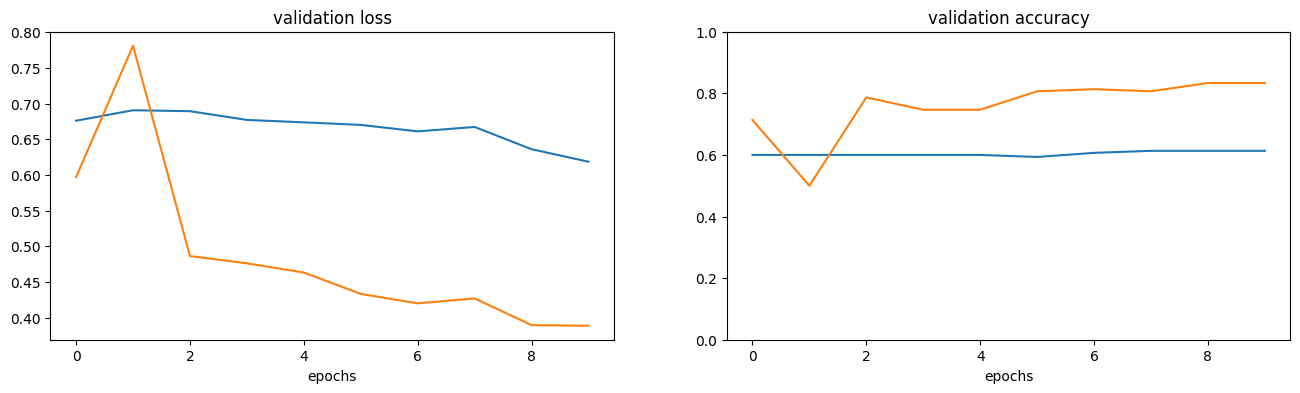

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

**Final Evaluation of the Transfer Learning Model**

The output shows the Test loss, which is the final error score, and the Test accuracy, which is the percentage of correct predictions. The results of the VGG16-based model are significantly better than those of the model built from scratch, since VGG16 has already been trained on millions of images to recognize objects, textures, and patterns—it does not start from zero.

In [ ]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.346112459897995
Test accuracy: 0.8666666746139526


**Final Test Prediction**

This code loads a single image, makes a prediction using the trained transfer learning model, and displays the result—in this case, whether the image is of a cat or a dog.

In [ ]:
img, x = get_image('/content/cats_and_dogs_dataset/PetImages/Dog/1.jpg')
probabilities = model_new.predict([x])
print(f"Probabilities of being Cat or Dog: {probabilities[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Probabilidades de ser Gato ou Cachorro: [1.4665319e-07 9.9999988e-01]
